In [16]:
# import argparse
import random
import copy
import torch
import torchvision
import numpy as np
import pandas as pd
import sklearn.metrics as sm
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()

torch.manual_seed(42)
random.seed(0)

device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# load data
test_seq = [
   torchvision.transforms.ToTensor(),
   torchvision.transforms.Normalize((0.1307,), (0.3081,))
]
test_transform = torchvision.transforms.Compose(test_seq)
train_transform = torchvision.transforms.Compose([torchvision.transforms.RandomAffine(10, shear=10)] + test_seq)
train_dataset = torchvision.datasets.MNIST('.', train=True, download=True, transform=train_transform)

train_subset, val_subset = torch.utils.data.random_split(
        train_dataset, [50000, 10000], generator=torch.Generator().manual_seed(1))

train_loader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_subset, batch_size=64, shuffle=False)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('.', train=False, transform=test_transform),
    batch_size=1000, shuffle=True)

In [17]:
# create imbalanced data
torch.manual_seed(42)
num_classes = 10


# create imbalanced data
classe_labels = range(num_classes)
sample_probs = torch.rand(num_classes)

idx_to_del = [i for i, label in enumerate(train_subset.dataset.train_labels) 
              if random.random() > sample_probs[label]]

imbalanced_train_dataset = copy.deepcopy(train_dataset)
imbalanced_train_dataset.targets = np.delete(train_subset.dataset.targets, idx_to_del, axis=0)
imbalanced_train_dataset.data = np.delete(train_subset.dataset.data, idx_to_del, axis=0)
imbalanced_train_loader = torch.utils.data.DataLoader(
    imbalanced_train_dataset, batch_size=64, shuffle=True, **kwargs)

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Original dataset: 50000 training samples & 10000 testing samples

Distribution of classes in original dataset:


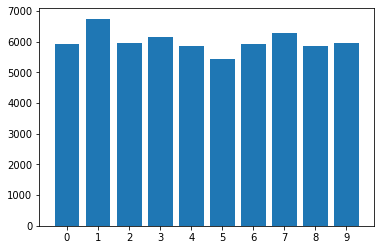

Sampling probability for each class:


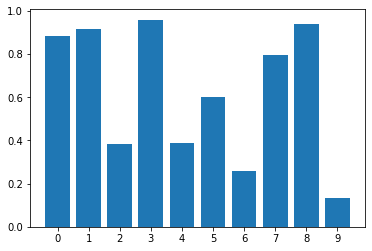

Imbalanced dataset: 37747 training samples & 10000 testing samples

Distribution of classes in imbalanced dataset:


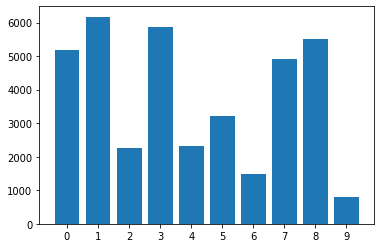

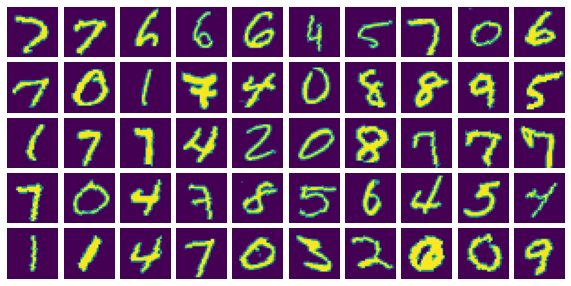

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

!pip install seaborn
import seaborn as sns

def show_mnist(arr, nrow=5, ncol=10, figsize=None):
    if figsize is None:
        figsize = (ncol, nrow)
        
    f, a = plt.subplots(nrow, ncol, figsize=figsize)
    
    def _do_show(the_figure, the_array):
        the_figure.imshow(the_array)
        the_figure.axis('off')
    
    for i in range(nrow):
        for j in range(ncol):
            _do_show(a[i][j], np.reshape(arr[i * ncol + j], (28, 28)))
            
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.draw()
        
    
def vis(test_accs, confusion_mtxes, labels, figsize=(20, 8)):
    cm = confusion_mtxes[np.argmax(test_accs)]
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%' % p
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    
    fig = plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plt.plot(test_accs, 'g')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    sns.heatmap(cm, annot=annot, fmt='', cmap="Blues")
    plt.show()
        
 
print('Original dataset: %d training samples & %d testing samples\n' % (
    len(train_loader.dataset), len(test_loader.dataset)))
 
print('Distribution of classes in original dataset:')
fig, ax = plt.subplots()
_, counts = np.unique(train_subset.dataset.train_labels, return_counts=True)
ax.bar(classe_labels, counts)
ax.set_xticks(classe_labels)
plt.show()

print('Sampling probability for each class:')
fig, ax = plt.subplots()
ax.bar(classe_labels, sample_probs)
ax.set_xticks(classe_labels)
plt.show()
 
print('Imbalanced dataset: %d training samples & %d testing samples\n' % (
    len(imbalanced_train_loader.dataset), len(test_loader.dataset)))

print('Distribution of classes in imbalanced dataset:')
fig, ax = plt.subplots()
_, counts = np.unique(imbalanced_train_loader.dataset.train_labels, return_counts=True)
ax.bar(classe_labels, counts)
ax.set_xticks(classe_labels)
plt.show()

for data, _ in train_loader:
    show_mnist(data)
    break 

In [19]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = torch.nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = torch.nn.Dropout2d()
        self.fc1 = torch.nn.Linear(320, 50)
        self.fc2 = torch.nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

@torch.no_grad()
def val_loss(x, y, model, weight=None):
    prediction = model(x)
    val_loss = F.nll_loss(prediction, y, weight)
    return val_loss.item()
    
def process(train_loader, test_loader, weight=None, model=None):
    if model is None:
      model = Net().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

    # train & test process
    def train(train_loader):
      model.train()
      train_epoch_losses = []
      for batch_idx, (data, target) in enumerate(train_loader):
          data, target = data.to(device), target.to(device)
          optimizer.zero_grad()
          output = model(data)
          loss = F.nll_loss(output, target, weight)
          loss.backward()
          optimizer.step()
          train_epoch_losses.append(loss)
      return train_epoch_losses


    def test(test_loader):
        model.eval()
        correct = 0
        targets, preds = [], []
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()
                
                targets += list(target.cpu().numpy())
                preds += list(pred.cpu().numpy())

        test_acc = 100. * correct / len(test_loader.dataset)
        confusion_mtx = sm.confusion_matrix(targets, preds)
        return test_acc, confusion_mtx

    
    train_losses, val_losses, test_accs, confusion_mtxes = [], [], [], []
    for epoch in range(1, 20 + 1):
        train_epoch_losses = train(train_loader)
        train_epoch_losses = torch.tensor(train_epoch_losses ).to('cpu')
        train_epoch_loss = train_epoch_losses.mean()

        for _, batch in enumerate(iter(val_loader)):
          x, y = batch
          x, y = x.to(device), y.to(device)
          validation_loss = val_loss(x, y, model)

        test_acc, confusion_mtx = test(test_loader)
        test_accs.append(test_acc)
        train_losses.append(train_epoch_loss)
        val_losses.append(validation_loss)

        confusion_mtxes.append(confusion_mtx)
        print('\rBest test acc = %2.2f%%' % max(test_accs))
        
    vis(test_accs, confusion_mtxes, classe_labels)
    return model, train_losses, val_losses

Best test acc = 89.26%
Best test acc = 93.78%
Best test acc = 95.42%
Best test acc = 95.68%
Best test acc = 96.44%
Best test acc = 96.47%
Best test acc = 96.77%
Best test acc = 97.13%
Best test acc = 97.33%
Best test acc = 97.33%
Best test acc = 97.52%
Best test acc = 97.71%
Best test acc = 97.71%
Best test acc = 97.89%
Best test acc = 97.89%
Best test acc = 97.89%
Best test acc = 97.89%
Best test acc = 98.04%
Best test acc = 98.08%
Best test acc = 98.12%


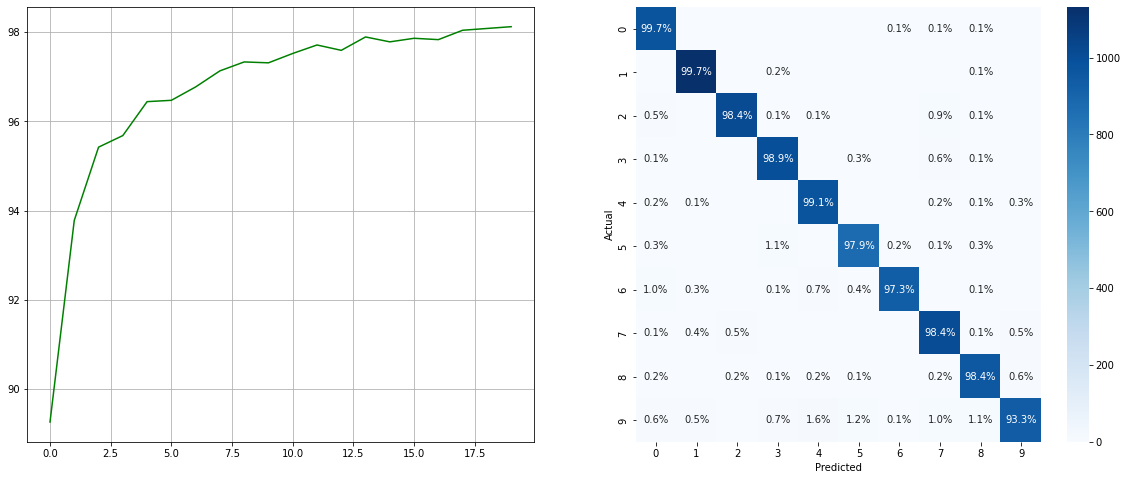

In [20]:
model, train_losses, val_losses = process(imbalanced_train_loader, test_loader)

In [21]:
print(train_losses)
print(val_losses)

[tensor(1.1223), tensor(0.4808), tensor(0.3748), tensor(0.3234), tensor(0.2868), tensor(0.2636), tensor(0.2424), tensor(0.2352), tensor(0.2282), tensor(0.2187), tensor(0.2048), tensor(0.2003), tensor(0.1944), tensor(0.1882), tensor(0.1872), tensor(0.1755), tensor(0.1821), tensor(0.1745), tensor(0.1679), tensor(0.1701)]
[0.505067765712738, 0.525388240814209, 0.12283188849687576, 0.23548907041549683, 0.17013701796531677, 0.8099597692489624, 0.3601578176021576, 0.15990392863750458, 0.1361912488937378, 0.09882927685976028, 0.051704585552215576, 0.17917971312999725, 0.11727196723222733, 0.05001829192042351, 0.09178309887647629, 0.12238922715187073, 0.049140214920043945, 0.09079702943563461, 0.4856165945529938, 0.26303747296333313]


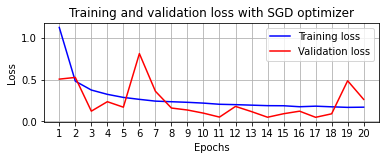

In [22]:
epochs = np.arange(20)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with SGD optimizer')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

In [23]:
# use the class_weights obtained using sklearn's compute_class_weight function
from sklearn.utils import class_weight
y = imbalanced_train_loader.dataset.targets
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y),y=y.numpy())
class_weights

array([0.72969263, 0.61128745, 1.67170062, 0.6417375 , 1.62983592,
       1.17081266, 2.52657296, 0.76815222, 0.68493921, 4.718375  ])

Best test acc = 84.82%
Best test acc = 91.78%
Best test acc = 93.58%
Best test acc = 93.83%
Best test acc = 95.62%
Best test acc = 96.24%
Best test acc = 96.72%
Best test acc = 96.72%
Best test acc = 96.88%
Best test acc = 97.43%
Best test acc = 97.43%
Best test acc = 97.56%
Best test acc = 97.66%
Best test acc = 97.66%
Best test acc = 97.68%
Best test acc = 98.02%
Best test acc = 98.02%
Best test acc = 98.06%
Best test acc = 98.20%
Best test acc = 98.20%


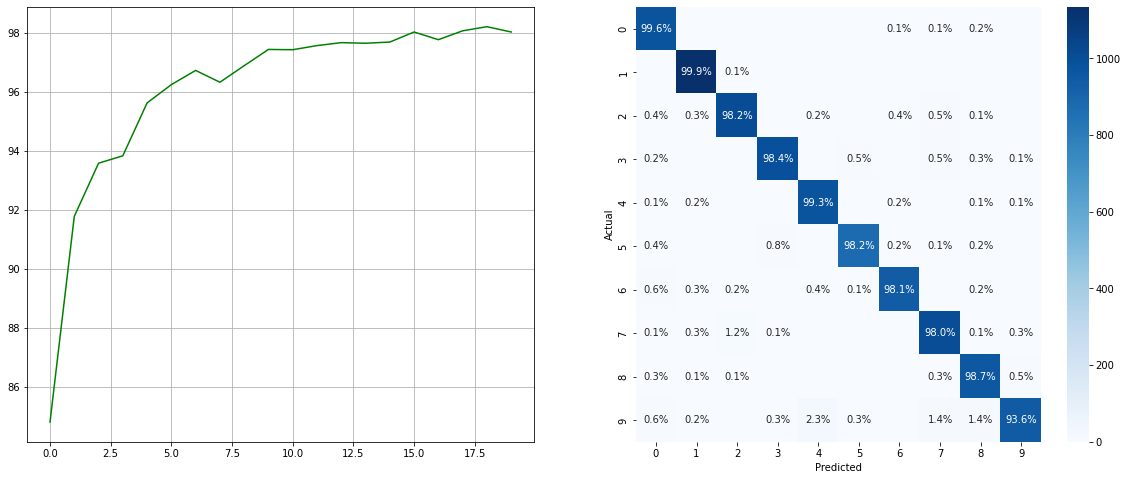

In [24]:
model, train_losses_first_pass, val_losses_first_pass  = process(imbalanced_train_loader, test_loader)

Best test acc = 98.15%
Best test acc = 98.33%
Best test acc = 98.42%
Best test acc = 98.42%
Best test acc = 98.47%
Best test acc = 98.47%
Best test acc = 98.47%
Best test acc = 98.50%
Best test acc = 98.50%
Best test acc = 98.50%
Best test acc = 98.54%
Best test acc = 98.57%
Best test acc = 98.57%
Best test acc = 98.57%
Best test acc = 98.57%
Best test acc = 98.57%
Best test acc = 98.57%
Best test acc = 98.61%
Best test acc = 98.61%
Best test acc = 98.61%


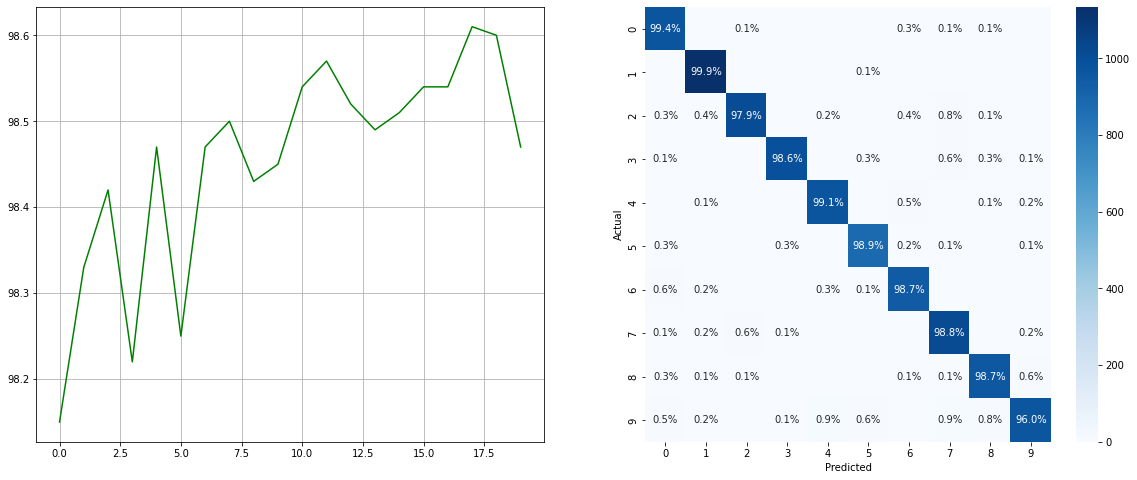

In [25]:
model, train_losses_second_pass, val_losses_second_pass = process(imbalanced_train_loader, test_loader, weight=torch.from_numpy(class_weights).cuda(0).float(), model=model)

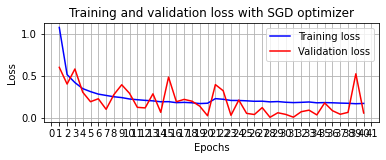

In [27]:
epochs = np.arange(40)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses_first_pass+train_losses_second_pass, 'b', label='Training loss')
plt.plot(epochs, val_losses_first_pass+val_losses_second_pass, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with SGD optimizer')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

As we can see, although for some classes the accuracy dropped, the accuracy actually improved for the most imbalanced classes of 9,6 and 2(in order).

After applying 2 phase training of deferred-reweighting technique, we see the accuracies of most imbalanced classes change as follows when compared to just reweighting:
* class 9: from 93.6% to 96.0%
* class 6: from 98.1% to 98.7%

